In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
class ProjectKNN:
    data = None
    data_train = None
    data_test = None
    model = None
    optimizer = None
    loss_function = None
    model_loss = 10000
    early_stop = 0

    def __init__(self, data_path='LocTreino_Equipe_3.csv', log_dir='log_mlp/'):
        self.data = pd.read_csv(data_path)
        self.preproccess_data()
        self.split_data()
        self.declare_model()

    def preproccess_data(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.dropna()

    def split_data(self):
        self.X = self.data[[
            x for x in self.data.columns if x not in ('lat', 'lon')]].values
        self.y = self.data[[
            x for x in self.data.columns if x in ('lat', 'lon')]].values

        self.data_train = self.data_test = self.data
        self.data_train = self.data_train[:int(0.9 * len(self.data_train))]
        self.data_test = self.data_test[int(0.9 * len(self.data_test)):]

    def declare_model(self):
        params = {'n_neighbors': [1, 3, 5, 8, 13],
                  'metric': ['euclidian', 'manhattan'],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [30, 33, 55, 88]
                  }
        knn = KNeighborsRegressor()
        self.model = GridSearchCV(knn, params,
                                  verbose=1, cv=3, n_jobs=-1)

    def train(self):
        batch = self.data_train
        x_batch = batch[[
            x for x in batch.columns if x not in ('lat', 'lon')]].values
        y_batch = batch[[
            x for x in batch.columns if x in ('lat', 'lon')]].values

        self.model.fit(x_batch, y_batch)
        self.model = knn.model.best_estimator_
        print(self.model)

    def test(self):
        x_batch = self.data_test[[
            x for x in self.data_test.columns if x not in ('lat', 'lon')]].values
        y_batch = self.data_test[[
            x for x in self.data_test.columns if x in ('lat', 'lon')]].values

        out = self.model.predict(x_batch)
        return out, y_batch

In [3]:
knn = ProjectKNN()
knn.train()
out, y_batch = knn.test()

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='distance')


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.2s finished


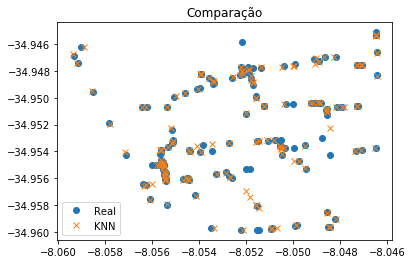

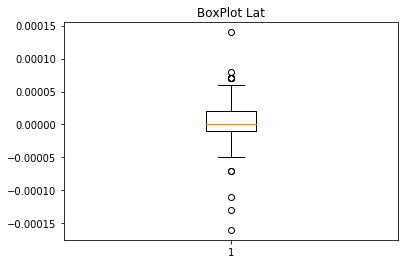

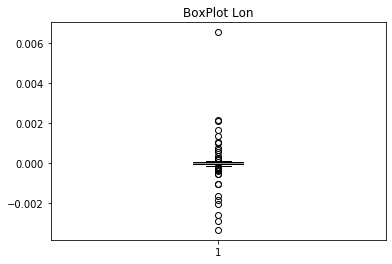

In [4]:
_, ax = plt.subplots()
ax.plot([x[0] for x in y_batch], [x[1] for x in y_batch], 'o', label='Real')
ax.plot([x[0] for x in out], [x[1] for x in out], 'x', label='KNN')
ax.legend()
ax.set_title('Comparação')
plt.show()
error = y_batch - out
errors_x = error[:, 0]
errors_y = error[:, 1]

_, ax = plt.subplots()
ax.boxplot(errors_x)
ax.set_title('BoxPlot Lat')
plt.show()

_, ax = plt.subplots()
ax.boxplot(errors_y)
ax.set_title('BoxPlot Lon')
plt.show()

In [22]:
dists = []
for i in range(len(out)):
    dists.append(np.linalg.norm(y_batch[i] - out[i]))

In [25]:
np.mean(dists), min(dists), max(dists), np.std(dists)

(0.0002976730611846374,
 9.999999996068709e-06,
 0.006540068806978588,
 0.0007602671122559543)